In [1]:
%pylab inline

import anacal
import numpy as np
import matplotlib.pylab as plt

import lsst.geom as geom
from numpy.lib import recfunctions as rfn
from astropy.visualization import simple_norm

from lsst.skymap.ringsSkyMap import (
    RingsSkyMap, RingsSkyMapConfig
)
from xlens.simulator.catalog import (
    CatalogShearTask,
    CatalogShearTaskConfig,
)
from xlens.simulator.sim import (
    MultibandSimConfig, MultibandSimTask
)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
config = RingsSkyMapConfig()
config.patchInnerDimensions = [501, 501]
config.tractOverlap = 0.0
config.patchBorder = 0        # pixels
config.numRings = 7000
config.pixelScale = 0.2
config.projection = "TAN"
skymap = RingsSkyMap(config=config)

config = CatalogShearTaskConfig()
config.kappa_value = 0.0000
config.layout="grid"
config.test_target="g2"
cattask = CatalogShearTask(config=config)
catalog = cattask.run(
    tract_info=skymap[0],
    seed=0,
).truthCatalog

config = MultibandSimConfig()
config.survey_name = (
    "lsst" 
)
simtask = MultibandSimTask(config=config)
outcome = simtask.run(
    tract_info=skymap[0],
    patch_id=0,
    band="i",
    seed=0,
    truthCatalog=catalog,
)

In [3]:
gal_array = np.asarray(
    outcome.simExposure.getMaskedImage().getImage().array,
    np.float64,
)
lsst_psf = outcome.simExposure.getPsf()
psf_array = np.asarray(
    anacal.utils.resize_array(
        lsst_psf.computeImage(
            geom.Point2D(250, 250)
        ).getArray(), (64, 64)
    ),
    dtype=np.float64,
)

Text(0.5, 1.0, 'PSF')

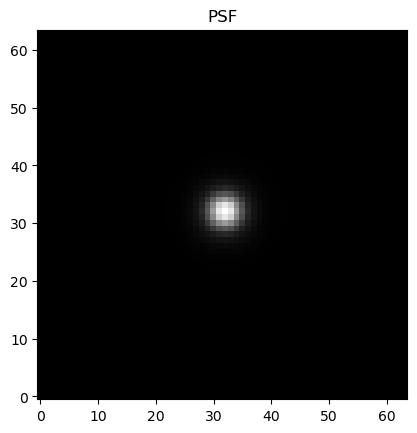

In [4]:
plt.close()
# Display the PSF image simulation
plt.imshow(psf_array, cmap="Greys_r", origin="lower")
plt.title("PSF")

In [5]:
noise_variance = 0.24
fpfs_c0 = 8.4
sigma_arcsec = 0.38
mag_zero = 27.0
pixel_scale = 0.2

class MyPsf(anacal.psf.BasePsf):
    def __init__(self, psf_array):
        super().__init__()
        self.psf_array = psf_array

    # accept *args/**kwargs for compatibility with flexible C++ signature
    def draw(self, x, y, *args, color=1.0, **kwargs):
        return self.psf_array

psf_object = MyPsf(psf_array)
def process_image(
    gal_array,
    psf_object,
    pixel_scale,
    noise_variance,
    noise_array=None,
    mask_array=None,
    omega_f=0.06,
    vmin=0.013,
    omega_v=0.025,
    p_min=0.06,
    omega_p=0.05,
    det_block_size=400,
    det_block_overlap=80,
):
    height, width = gal_array.shape
    blocks = anacal.geometry.get_block_list(
        img_ny=height,
        img_nx=width,
        block_nx=det_block_size,
        block_ny=det_block_size,
        block_overlap=det_block_overlap,
        scale=pixel_scale,
    )
    # attach PSF if your block objects expect it
    for b in blocks:
        b.psf_array = psf_object.psf_array

    # prior
    prior = anacal.ngmix.modelPrior()
    prior.set_sigma_a(anacal.math.qnumber(0.05))
    prior.set_sigma_x(anacal.math.qnumber(0.05))

    # photometric scaling
    ratio = 10.0 ** ((mag_zero - 30.0) / 2.5)

    det_task = anacal.task.Task(
        scale=pixel_scale,
        omega_f=omega_f*ratio,
        v_min=vmin*ratio,       
        omega_v=omega_v*ratio,
        fpfs_c0=fpfs_c0*ratio,
        p_min=p_min,
        omega_p=omega_p,
        sigma_arcsec=sigma_arcsec,
        snr_peak_min=5,
        stamp_size=64,
        image_bound=40,
        num_epochs=0,
        force_size=True,
        force_center=True,
        prior=prior,
    )

    detection = det_task.process_image(
        gal_array,
        psf_object.psf_array,    
        variance=noise_variance,
        block_list=blocks,
        detection=None,
        noise_array=noise_array,
        mask_array=mask_array,
    )

    fpfs_peaks_dtype = np.dtype([("y", np.float64), ("x", np.float64)])
    det = np.zeros(len(detection), dtype=fpfs_peaks_dtype)
    det["x"] = detection["x1_det"] / pixel_scale
    det["y"] = detection["x2_det"] / pixel_scale

    fpfs_config = anacal.fpfs.FpfsConfig(
        sigma_shapelets1=sigma_arcsec * np.sqrt(2.0),
    )

    catalog = anacal.fpfs.process_image(
        fpfs_config=fpfs_config,
        pixel_scale=pixel_scale,
        mag_zero=mag_zero,
        noise_variance=noise_variance,
        gal_array=gal_array,
        psf_array=psf_object.psf_array,  
        mask_array=mask_array,
        noise_array=noise_array,
        detection=det,
        psf_object=psf_object, 
        do_compute_detect_weight=False,
    )
    catalog = rfn.merge_arrays(
        [catalog, det, detection[["wsel", "dwsel_dg1", "dwsel_dg2"]]], 
        flatten=True
    )
    return catalog

In [6]:
config = CatalogShearTaskConfig()
config.kappa_value = 0.0000
config.layout="grid"
config.mode=0
cattask = CatalogShearTask(config=config)
catalog = cattask.run(
    tract_info=skymap[0],
    seed=0,
).truthCatalog

config = MultibandSimConfig()
config.survey_name = (
    "lsst" 
)
simtask = MultibandSimTask(config=config)
outcome = simtask.run(
    tract_info=skymap[0],
    patch_id=0,
    band="i",
    seed=0,
    truthCatalog=catalog,
)
gal_array1 = np.asarray(
    outcome.simExposure.getMaskedImage().getImage().array,
    np.float64,
)
out1 = process_image(gal_array1, psf_object, pixel_scale, noise_variance)


config = CatalogShearTaskConfig()
config.kappa_value = 0.0000
config.layout="grid"
config.mode=1
cattask = CatalogShearTask(config=config)
catalog = cattask.run(
    tract_info=skymap[0],
    seed=0,
).truthCatalog

config = MultibandSimConfig()
config.survey_name = (
    "lsst" 
)
simtask = MultibandSimTask(config=config)
outcome = simtask.run(
    tract_info=skymap[0],
    patch_id=0,
    band="i",
    seed=0,
    truthCatalog=catalog,
)
gal_array2 = np.asarray(
    outcome.simExposure.getMaskedImage().getImage().array,
    np.float64,
)
out2 = process_image(gal_array2, psf_object, pixel_scale, noise_variance)

Text(0.5, 1.0, 'Exposure')

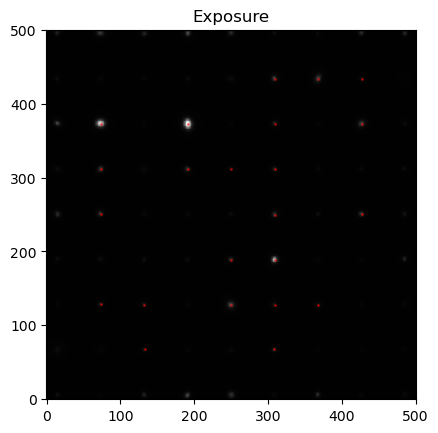

In [7]:
plt.scatter(out1["x"], out1["y"], marker="o", alpha=0.5, s=1.0, color="red")
plt.imshow(
    gal_array1,
    aspect="equal",
    cmap="Greys_r",
    origin="lower",
    interpolation="None",
    norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),
)
plt.title("Exposure")

Text(0.5, 1.0, 'Exposure')

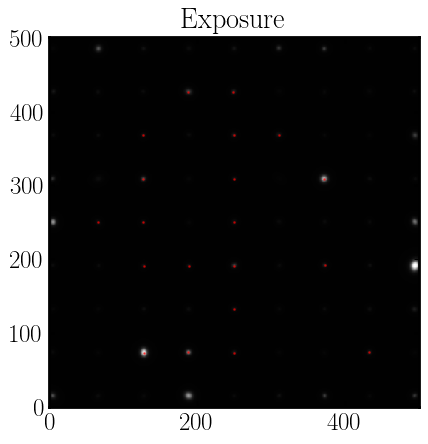

In [8]:
plt.scatter(out2["x"], out2["y"], marker="o", alpha=0.5, s=1.0, color="red")
plt.imshow(
    gal_array2,
    aspect="equal",
    cmap="Greys_r",
    origin="lower",
    interpolation="None",
    norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),
)
plt.title("Exposure")

In [9]:
e1_1 = out1["wsel"] * out1["fpfs1_e1"]
e1g1_1 = out1["dwsel_dg1"] * out1["fpfs1_e1"] + out1["wsel"] * out1["fpfs1_de1_dg1"]
e1_2 = out2["wsel"] * out2["fpfs1_e1"]
e1g1_2 = out2["dwsel_dg1"] * out2["fpfs1_e1"] + out2["wsel"] * out2["fpfs1_de1_dg1"]
print((np.sum(e1_2) - np.sum(e1_1)) / (np.sum(e1g1_1) + np.sum(e1g1_2)))

-0.002295536796397606
